In [1]:
import numpy as np
import pyproj
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.rcParams["font.size"] = 20

import torch
from OkadaTorch import OkadaWrapper
okada = OkadaWrapper()

In [2]:
# domain
lon_min, lon_max = 142, 148
lat_min, lat_max = 37, 43
dlon, dlat = 0.05, 0.05
nlon, nlat = int((lon_max-lon_min)/dlon)+1, int((lat_max-lat_min)/dlon)+1
lon_mid, lat_mid = (lon_min+lon_max)/2, (lat_min+lat_max)/2


# coordinate transformation
ll2xy = pyproj.Transformer.from_crs(
    crs_from="EPSG:4326", # WGS84
    crs_to=f"+proj=tmerc +lon_0={lon_mid} +lat_0={lat_mid} +ellps=WGS84 +datum=WGS84 +units=km", 
    always_xy=True
)

lon = np.linspace(lon_min, lon_max, nlon)
lat = np.linspace(lat_min, lat_max, nlat)
Lon, Lat = np.meshgrid(lon, lat)
x, y = ll2xy.transform(Lon, Lat)
X = torch.from_numpy(x)
Y = torch.from_numpy(y)

z = np.zeros_like(x)
Z = torch.from_numpy(z)


# source parameters
lat_fault = 40.2224
lon_fault = 144.8678
x_fault, y_fault = ll2xy.transform(lon_fault, lat_fault)


# specify `requires_grad=True`
x_fault = torch.tensor(x_fault, requires_grad=True) # km
y_fault = torch.tensor(y_fault, requires_grad=True) # km
depth = torch.tensor(0.1, requires_grad=True) # km
length = torch.tensor(218.0, requires_grad=True) # km
width = torch.tensor(46.0, requires_grad=True) # km
strike = torch.tensor(189.0, requires_grad=True)
dip = torch.tensor(60.0, requires_grad=True)
rake = torch.tensor(270.0, requires_grad=True)
slip = torch.tensor(5.62, requires_grad=True)

In [3]:
coords = {
    "x": X,
    "y": Y,
    "z": Z
}
params = {
    "x_fault": x_fault,
    "y_fault": y_fault,
    "depth": depth,
    "length": length,
    "width": width,
    "strike": strike,
    "dip": dip,
    "rake": rake,
    "slip": slip
}

# Diagonal hessian of `ux`, `uy` and `uz` with respect to `x`, `y` and `z`

Note: In the following, `uijk` means $\dfrac{\partial^2 u_i}{\partial x_j \partial x_k}$

In [4]:
# as the gradient of strain
uxx, uyx, uzx, uxxx, uyxx, uzxx, uxyx, uyyx, uzyx, uxzx, uyzx, uzzx = okada.gradient(
    coords, params, arg="x", compute_strain=True, is_degree=True, fault_origin="topleft"
)
uxy, uyy, uzy, uxxy, uyxy, uzxy, uxyy, uyyy, uzyy, uxzy, uyzy, uzzy = okada.gradient(
    coords, params, arg="y", compute_strain=True, is_degree=True, fault_origin="topleft"
)
uxz, uyz, uzz, uxxz, uyxz, uzxz, uxyz, uyyz, uzyz, uxzz, uyzz, uzzz = okada.gradient(
    coords, params, arg="z", compute_strain=True, is_degree=True, fault_origin="topleft"
)

# as the hessian of displacement
UXXX, UYXX, UZXX = okada.hessian(coords, params, arg1="x", arg2="x", compute_strain=False, is_degree=True, fault_origin="topleft")
UXYY, UYYY, UZYY = okada.hessian(coords, params, arg1="y", arg2="y", compute_strain=False, is_degree=True, fault_origin="topleft")
UXZZ, UYZZ, UZZZ = okada.hessian(coords, params, arg1="z", arg2="z", compute_strain=False, is_degree=True, fault_origin="topleft")

In [5]:
# errors are very small
print(torch.abs(UXXX-uxxx).max())
print(torch.abs(UXYY-uxyy).max())
print(torch.abs(UXZZ-uxzz).max())
print(torch.abs(UYXX-uyxx).max())
print(torch.abs(UYYY-uyyy).max())
print(torch.abs(UYZZ-uyzz).max())
print(torch.abs(UZXX-uzxx).max())
print(torch.abs(UZYY-uzyy).max())
print(torch.abs(UZZZ-uzzz).max())

tensor(4.4078e-07, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(1.1080e-08, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(1.4703e-06, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(6.9812e-08, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(4.3944e-09, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(2.3288e-07, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(7.7290e-07, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(1.9398e-08, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(7.9227e-07, dtype=torch.float64, grad_fn=<MaxBackward1>)


# Diagonal hessian of `uz` with respect to parameters

In [6]:
# import os
# os.makedirs("figs_hessian", exist_ok=True)

In [5]:
ss = torch.sin(torch.deg2rad(strike))
cs = torch.cos(torch.deg2rad(strike))
sd = torch.sin(torch.deg2rad(dip))
cd = torch.cos(torch.deg2rad(dip))

x_corners = [
    x_fault,
    x_fault               + width * cd * cs,
    x_fault + length * ss + width * cd * cs,
    x_fault + length * ss
]
y_corners = [
    y_fault,
    y_fault               - width * cd * ss,
    y_fault + length * cs - width * cd * ss,
    y_fault + length * cs
]

lon_corners, lat_corners = ll2xy.transform(x_corners, y_corners, direction = "INVERSE")
corners = np.column_stack((np.array(lon_corners), np.array(lat_corners)))

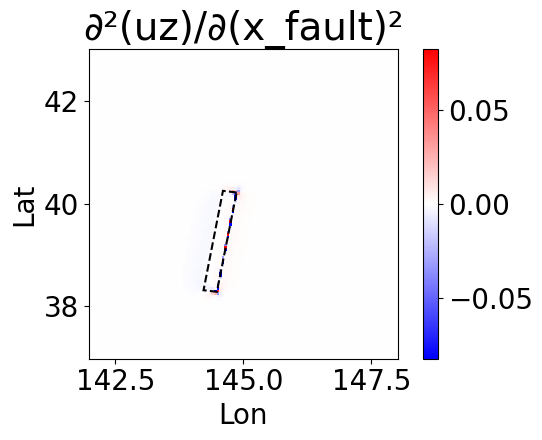

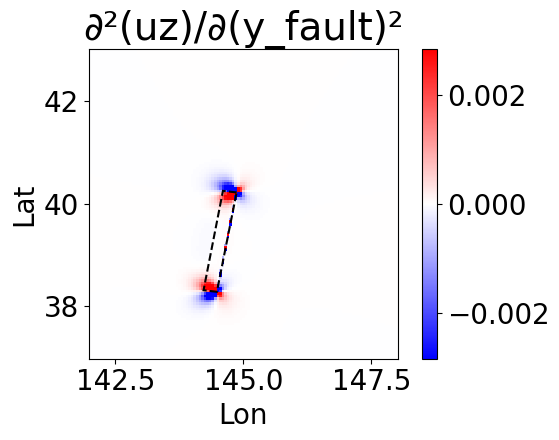

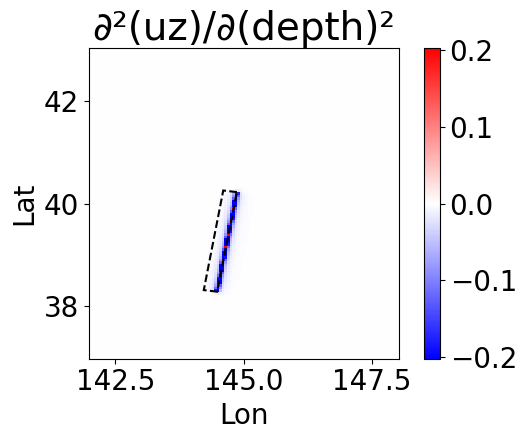

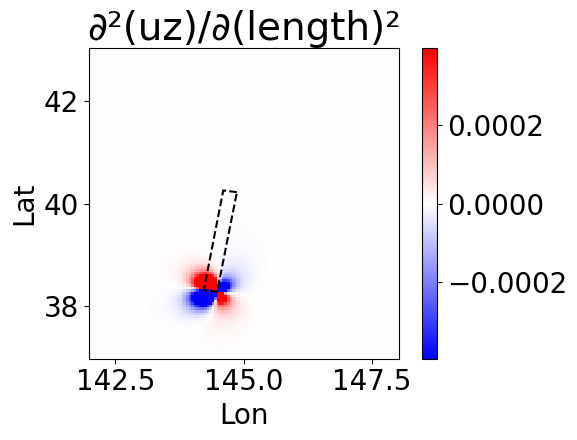

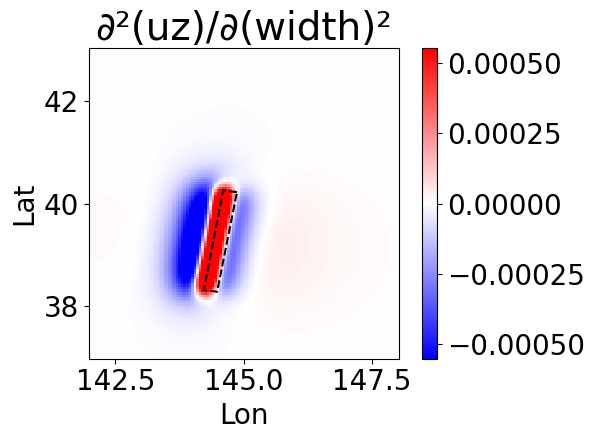

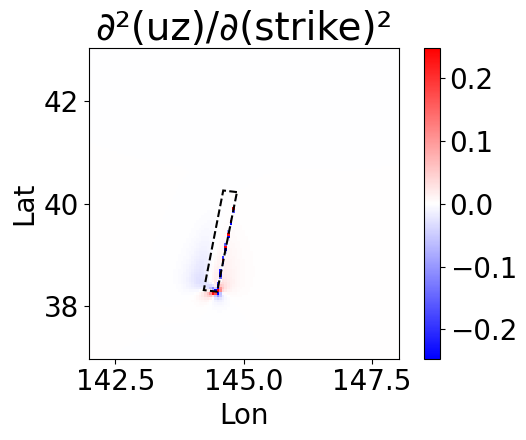

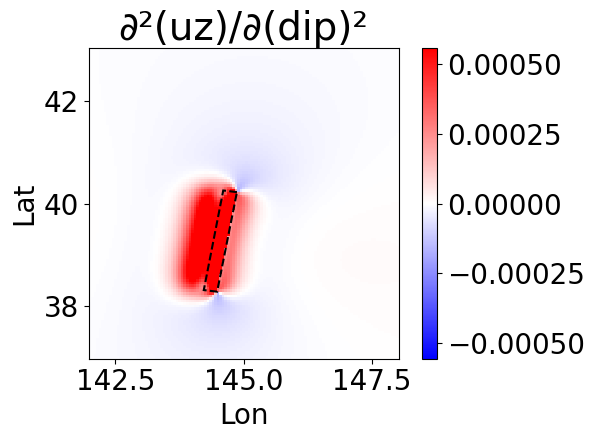

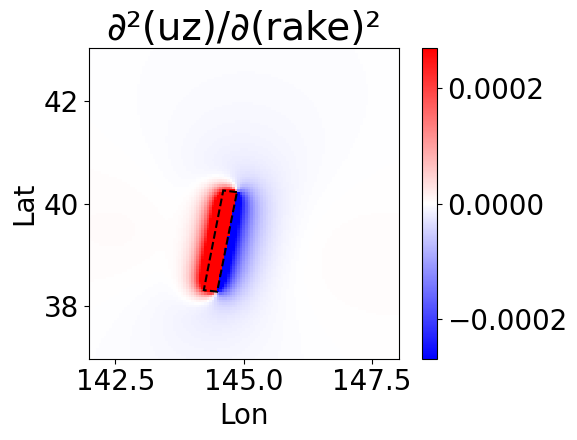

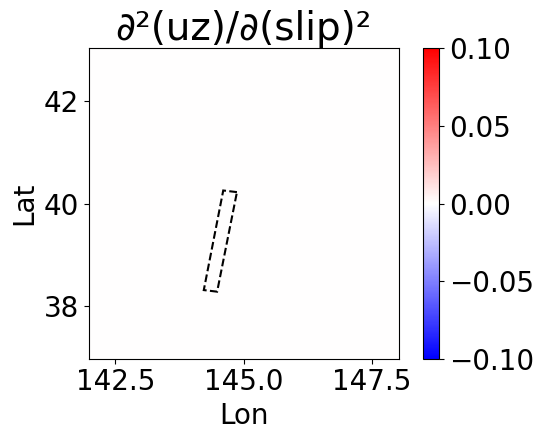

In [ ]:
for i, var in enumerate(list(params)):

    _, _, dduz = okada.hessian(coords, params, arg1=var, arg2=var, compute_strain=False, is_degree=True, fault_origin="topleft")

    amp = np.abs(dduz.detach().numpy()).mean() * 10

    fig, ax = plt.subplots()
    im = ax.pcolormesh(Lon, Lat, dduz.detach().numpy(), cmap="bwr", vmin=-amp, vmax=amp)
    rect = patches.Polygon(corners, ls="--", lw=1.5, closed=True, edgecolor='black', fill=False)
    ax.add_patch(rect)
    ax.set_aspect("equal")
    ax.set_xlabel("Lon")
    ax.set_ylabel("Lat")
    ax.set_title(f"∂²(uz)/∂({var})²", fontsize=28)
    fig.colorbar(im)
    fig.show()

    # plt.tight_layout()
    # fig.savefig(f"figs_hessian/∂uz2∂{var}2.png")

### For the case of `fault_origin = "center"`

In [6]:
x_corners = [
    x_fault - 0.5 * length * ss - 0.5 * width * cd * cs,
    x_fault - 0.5 * length * ss + 0.5 * width * cd * cs,
    x_fault + 0.5 * length * ss + 0.5 * width * cd * cs,
    x_fault + 0.5 * length * ss - 0.5 * width * cd * cs,
]
y_corners = [
    y_fault - 0.5 * length * cs + 0.5 * width * cd * ss,
    y_fault - 0.5 * length * cs - 0.5 * width * cd * ss,
    y_fault + 0.5 * length * cs - 0.5 * width * cd * ss,
    y_fault + 0.5 * length * cs + 0.5 * width * cd * ss,
]

lon_corners, lat_corners = ll2xy.transform(x_corners, y_corners, direction = "INVERSE")
corners = np.column_stack((np.array(lon_corners), np.array(lat_corners)))

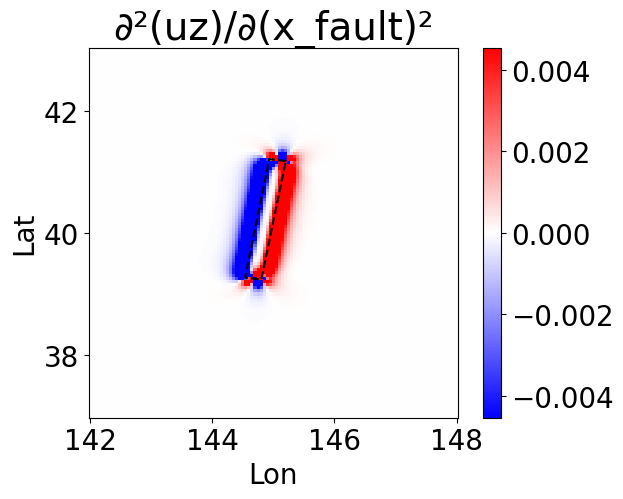

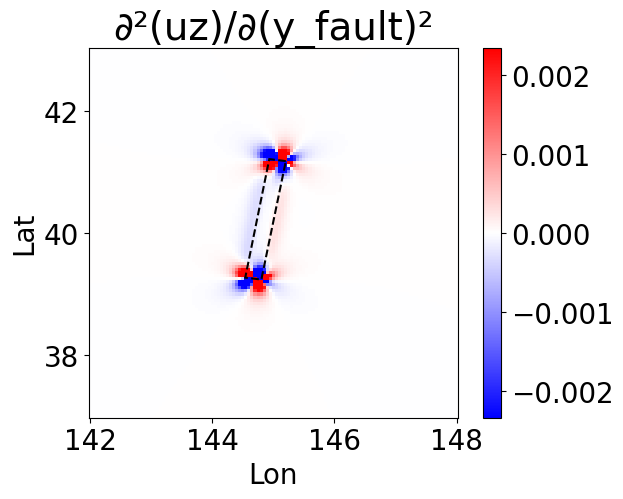

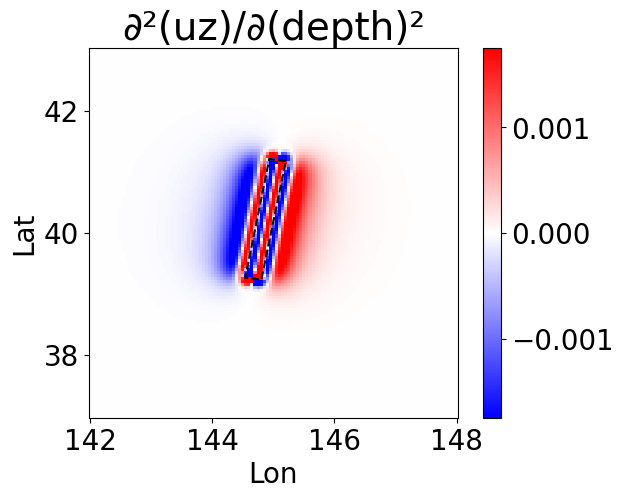

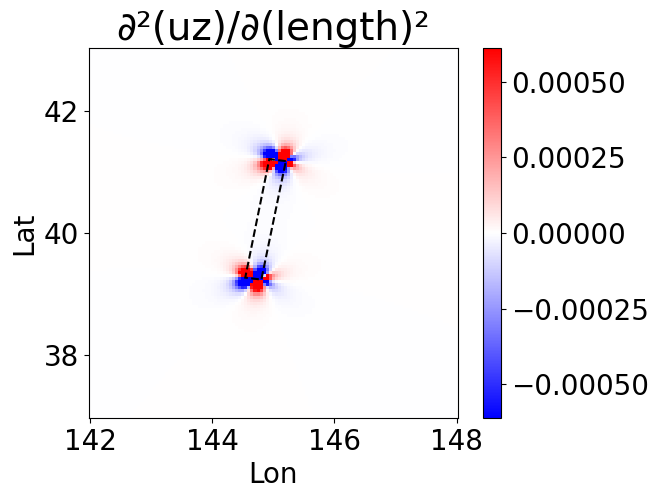

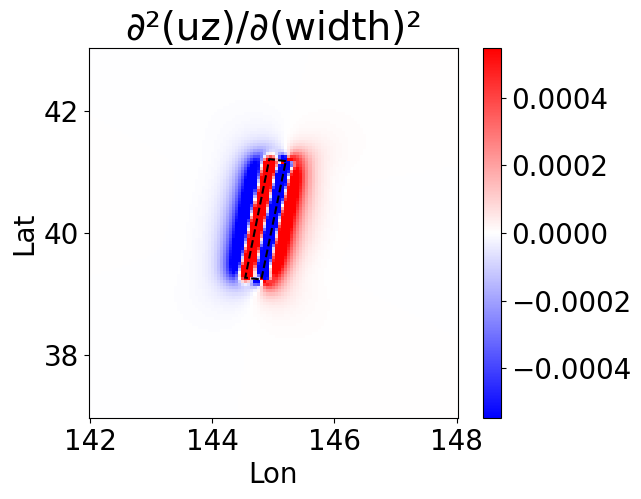

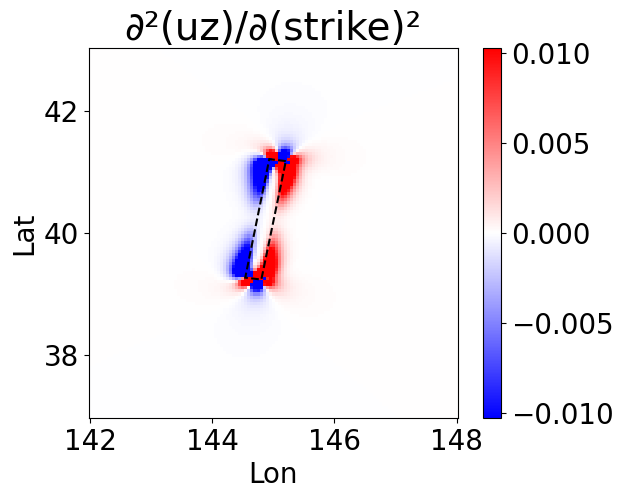

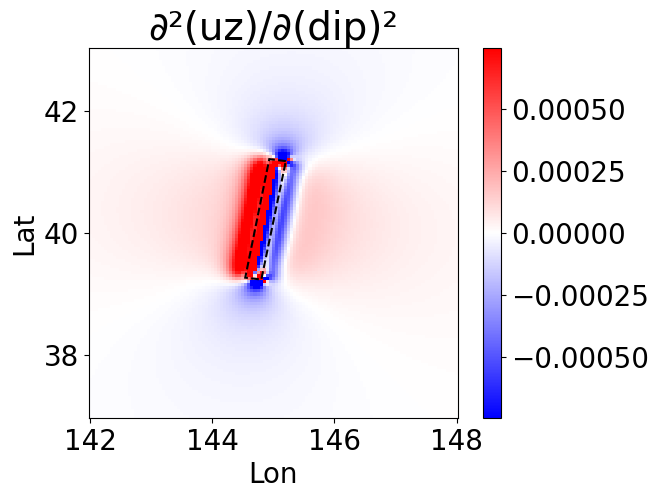

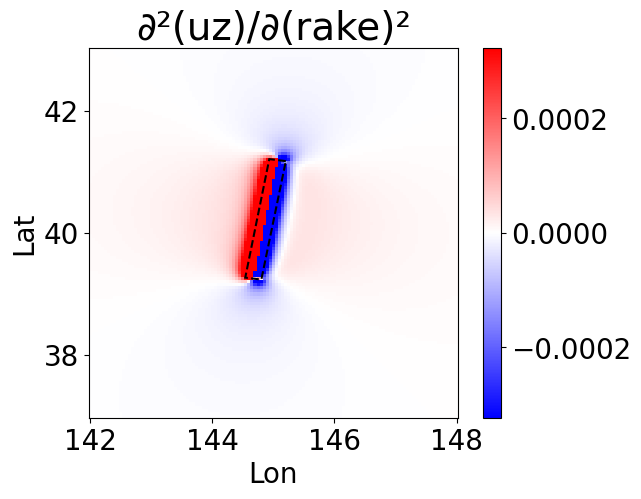

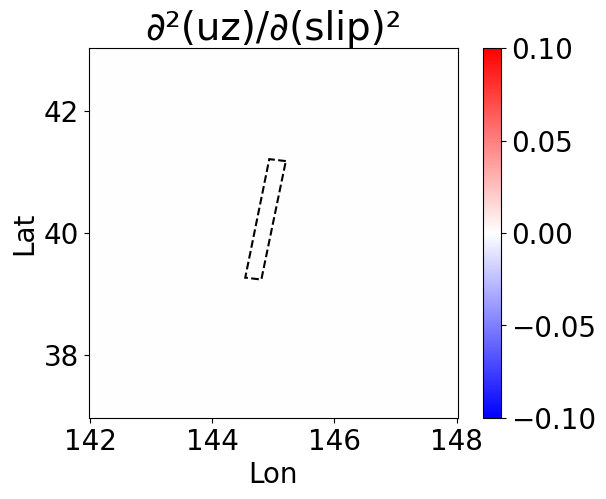

In [7]:
for i, var in enumerate(list(params)):

    _, _, dduz = okada.hessian(coords, params, arg1=var, arg2=var, compute_strain=False, is_degree=True, fault_origin="center")

    amp = np.abs(dduz.detach().numpy()).mean() * 10

    fig, ax = plt.subplots()
    im = ax.pcolormesh(Lon, Lat, dduz.detach().numpy(), cmap="bwr", vmin=-amp, vmax=amp)
    rect = patches.Polygon(corners, ls="--", lw=1.5, closed=True, edgecolor='black', fill=False)
    ax.add_patch(rect)
    ax.set_aspect("equal")
    ax.set_xlabel("Lon")
    ax.set_ylabel("Lat")
    ax.set_title(f"∂²(uz)/∂({var})²", fontsize=28)
    fig.colorbar(im)
    fig.show()